In [1]:
# https://www.packtpub.com/mapt/book/big_data_and_business_intelligence/9781787282773/4/ch04lvl1sec32/exploring-rnns

In [2]:
import tensorflow as tf
import numpy as np
import datetime
import math

In [3]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(x, *args, **kwargs):
        return x

In [6]:
# read in data
filename = 'weather.npz'
data = np.load(filename)
daily = data['daily']
weekly = data['weekly']

num_weeks = len(weekly)
dates = np.array([datetime.datetime.strptime(str(int(d)),
                '%Y%m%d') for d in weekly[:,0]])

In [7]:
def assign_season(date):
    ''' Assign season based on meteorological season.
        Spring - from Mar 1 to May 31
        Summer - from Jun 1 to Aug 31
        Autumn - from Sep 1 to Nov 30
        Winter - from Dec 1 to Feb 28 (Feb 29 in a leap year)
    '''
    month = date.month
    # spring = 0
    if 3 <= month < 6:
        season = 0
    # summer = 1
    elif 6 <= month < 9:
        season = 1
    # autumn = 2
    elif 9 <= month < 12:
        season = 2
    # winter = 3
    elif month == 12 or month < 3:
        season = 3
    return season

In [8]:
# There are 4 seasons
num_classes = 4

# and 5 variables
num_inputs = 5

# And a state of 11 numbers
state_size = 11

In [9]:
labels = np.zeros([num_weeks,num_classes])
# read and convert to one-hot
for i,d in enumerate(dates):
    labels[i,assign_season(d)] = 1

In [10]:
# extract and scale training data
train = weekly[:,1:]
train = train - np.average(train,axis=0)
train = train / train.std(axis=0)

In [20]:
# Startup TensorFlow
sess = tf.InteractiveSession()

# These will be inputs
x = tf.placeholder("float", [None, num_inputs])
# TF likes a funky input to RNN
x_ = tf.reshape(x, [1, num_weeks, num_inputs])

## Known labels
# None works during variable creation to be
# unspecified size
y_ = tf.placeholder("float", [None,num_classes])

cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
outputs, states = tf.nn.dynamic_rnn(cell,x_,
            dtype=tf.float32, initial_state=None)

W1 = tf.Variable(tf.truncated_normal([state_size,num_classes],
                          stddev=1./math.sqrt(num_inputs)))
b1 = tf.Variable(tf.constant(0.1,shape=[num_classes]))

In [21]:
# reshape the output for traditional usage
h1 = tf.reshape(outputs,[-1,state_size])

In [23]:
# Just initialize
sess.run(tf.global_variables_initializer())

In [24]:
# Logistic regression as usual
y = tf.nn.softmax(tf.matmul(h1, W1) + b1)

In [26]:
# Climb on cross-entropy
cross_entropy = tf.reduce_mean(
     tf.nn.softmax_cross_entropy_with_logits(logits=y + 1e-50, labels=y_))

In [27]:
# How we train
train_step = tf.train.GradientDescentOptimizer(0.01
                    ).minimize(cross_entropy)

In [28]:
# Define accuracy
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction, "float"))

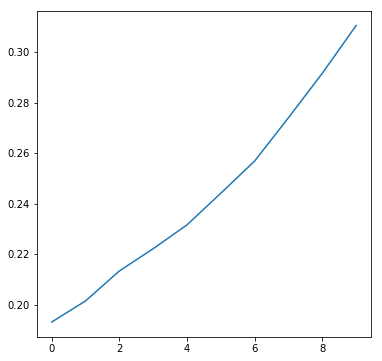

In [29]:
# Actually train
epochs = 100
train_acc = np.zeros(epochs//10)
for i in tqdm(range(epochs), ascii=True):
    if i % 10 == 0:  # Record summary data, and the accuracy
        # Check accuracy on train set
        A = accuracy.eval(feed_dict={x: train, y_: labels})
        train_acc[i//10] = A
    train_step.run(feed_dict={x: train, y_: labels})

import matplotlib.pyplot as plt
plt.ion()
plt.figure(figsize=(6, 6))
plt.plot(train_acc)